In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import calculate_qscore

# Load data

In [2]:
dataset_file = "data/labels/processed/global_mapped_cleaned.csv" # full dataset
save_file = "human-centric-differences"
raw_df = pd.read_csv(dataset_file, index_col=0)

In [4]:
indicators = raw_df["Question"].unique()
num_indicators = len(indicators)

indicators_pp2 = ['safe', 'lively', 'wealthy','beautiful', 'boring', 'depressing']
num_indicators_pp2 = len(indicators_pp2)

countries = raw_df["Country"].unique()
num_countries = len(countries)

# PlacePulse2.0 inferences

We use the same [model](https://github.com/ualsg/global-streetscapes/blob/main/code/model_training/perception/inference.py) used in the [Global Streetscapes dataset](https://github.com/ualsg/global-streetscapes/wiki/4b-Human-perception).
This model will be referred to as ViT-PP2

Run the next cells after having run `8_inference.py` as indicated in the `README.MD` file

In [5]:
for i, ind in enumerate(indicators_pp2):
    if i == 0:
        df_pp2 = pd.read_csv(f'data/labels/inferences/{ind}.csv')
    else:
        df_pp2 = pd.merge(df_pp2, pd.read_csv(f'data/labels/inferences/{ind}.csv'), on='uuid', how='left')

df_pp2

,uuid,safe,lively,wealthy,beautiful,boring,depressing
0,dc6eee81-9513-4edb-813b-05b83b5127be,2.95,4.59,5.12,6.71,3.70,6.67
1,50811b7a-5b0f-4581-92fa-017e6ff26ba0,7.58,9.07,8.57,6.93,2.10,2.03
2,35c8af9e-5e36-4810-9824-59b9b273fbcf,1.94,6.52,1.15,1.23,6.14,8.50
3,3a439403-305b-4be7-ba43-f8ff8e75c31c,3.07,5.93,4.13,5.59,1.99,4.85
4,3cc24150-c590-4d83-883c-44855010e338,5.55,4.82,7.42,8.03,4.71,2.58
...,...,...,...,...,...,...,...
395,dad8c5a5-80cd-4d1e-a3cc-b429cdbb90c2,8.61,8.63,7.31,4.99,1.14,5.09
396,b7abb7f7-7031-4fc9-8f16-7e591dcdfbce,7.65,8.11,7.95,7.61,8.56,2.03
397,41a8b6ce-02df-47e8-b7d1-10cce55b6575,5.81,7.53,8.73,9.13,2.67,1.62
398,e97e0042-0ca3-47a2-a514-7422cb60e6a6,5.94,6.97,8.34,5.54,4.52,5.69


# Filtering
In [PP2](https://arxiv.org/abs/1608.01769), page 6, the max comparison across all indicators are:
- min 2.40
- avg 4.05, however on page 7 they state 3.35
- max 7.67 

# Scores for all SVIs by raters of each country + PP2 model (global)

## Min

/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/920581243.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/920581243.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/920581243.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Min sample size across all subgroups and indicators: 333


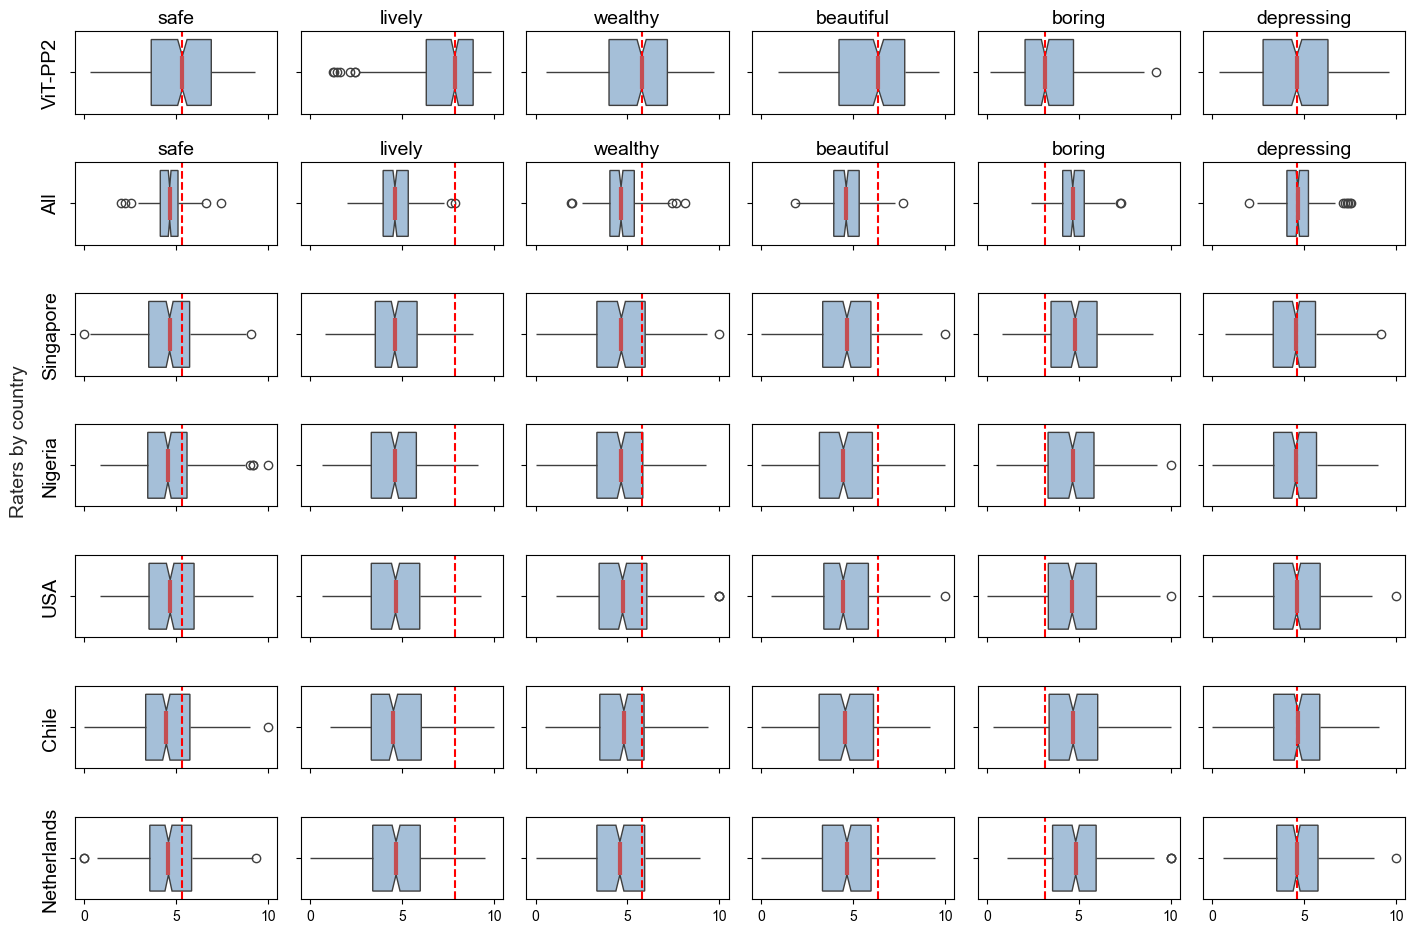

In [6]:
min_threshold = 3

# empty dataframe for later, start with PP2
min_df = pd.melt(df_pp2, id_vars=['uuid'], value_vars=['safe', 'lively', 'wealthy', 'beautiful', 'boring', 'depressing'], var_name='Question', value_name='Score')
min_df = min_df.rename(columns={'uuid': 'Image'})
min_df['Country'] = 'ViT-PP2'
min_df['Num_comparisons'] = 4

fig, axes = plt.subplots(
    2 + num_countries, num_indicators_pp2, figsize=(14, 10), sharey=True, sharex=True
)

sns.set(style="white")
fontsize = 14
plot_args = {
    'notch': True, 
    'showcaps': False,
    'boxprops': {"facecolor": (.3, .5, .7, .5)},
    'medianprops': {"color": "r", "linewidth": 3}
}

min_sample_size = 400

# Store medians for the first row
medians_first_row = []

# Plot the first row of boxplots
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_pp2[ind]
    
    # Calculate median of the first row for vertical line
    median_value = ind_df.median()
    medians_first_row.append(median_value)

    ax = axes[0, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df,
        ax=ax,
        **plot_args,
    )
    
    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("ViT-PP2", size=fontsize)

# Plot the second row of boxplots (all countries combined)
df_scores = calculate_qscore(raw_df)
df_scores_filtered = df_scores[df_scores['Num_comparisons'] >= min_threshold]
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_scores_filtered[df_scores_filtered['Question'] == ind]
    ind_df.loc[:, 'Country'] = 'All'
    
    min_df = pd.concat([min_df, ind_df], ignore_index=True)
    
    ax = axes[1, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df['Score'],
        ax=ax,
        **plot_args,
    )
    # Draw the vertical line using the median from the first row
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)
    
    if min_sample_size > len(ind_df):
        min_sample_size = len(ind_df)
        
    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("All", size=fontsize)

# Plot the remaining rows of boxplots and add vertical lines
for j, c in enumerate(countries):
    # calculate the Q-score for all SVI from ONLY participants of current country
    country_df = raw_df[raw_df['Country'] == c]
    country_df_scores = calculate_qscore(country_df)
    country_df_scores_filtered = country_df_scores[country_df_scores['Num_comparisons'] >= min_threshold]
    country_df_scores_filtered['Country'] = c
    min_df = pd.concat([min_df, country_df_scores_filtered], ignore_index=True)
    
    for i, ind in enumerate(indicators_pp2):
        # Filter by indicator
        ind_df = country_df_scores_filtered[country_df_scores_filtered['Question'] == ind]
    
        ax = axes[j + 2, i]  # Use the shared axes
    
        sns.boxplot(
            x=ind_df['Score'],
            ax=ax,
            **plot_args,
        )
    
        ax.set_xlabel("")
        ax.set_ylabel(c, size=fontsize)

        # Draw the vertical line using the median from the first row
        ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

        if min_sample_size > len(ind_df):
            min_sample_size = len(ind_df)
# Draw vertical lines for the first row boxplots (if you want them to extend across the first row as well)
for i, ax in enumerate(axes[0, :]):
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

# Add a shared y-axis label
print(f'Min sample size across all subgroups and indicators: {min_sample_size}')
fig.text(-0.01, 0.5, 'Raters by country', va='center', rotation='vertical', fontsize=fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to leave space for suptitle
plt.savefig(f"img/{save_file}_{min_threshold}.png", dpi=300)
plt.show()

# ViT-PP2 has 2 decimal points for precision
min_df['Score'] = round(min_df['Score'], 2)
min_df.to_csv(f'data/labels/processed/{save_file}_{min_threshold}.csv')

## Avg

/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/1504596587.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/1504596587.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/1504596587.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Min sample size across all subgroups and indicators: 285


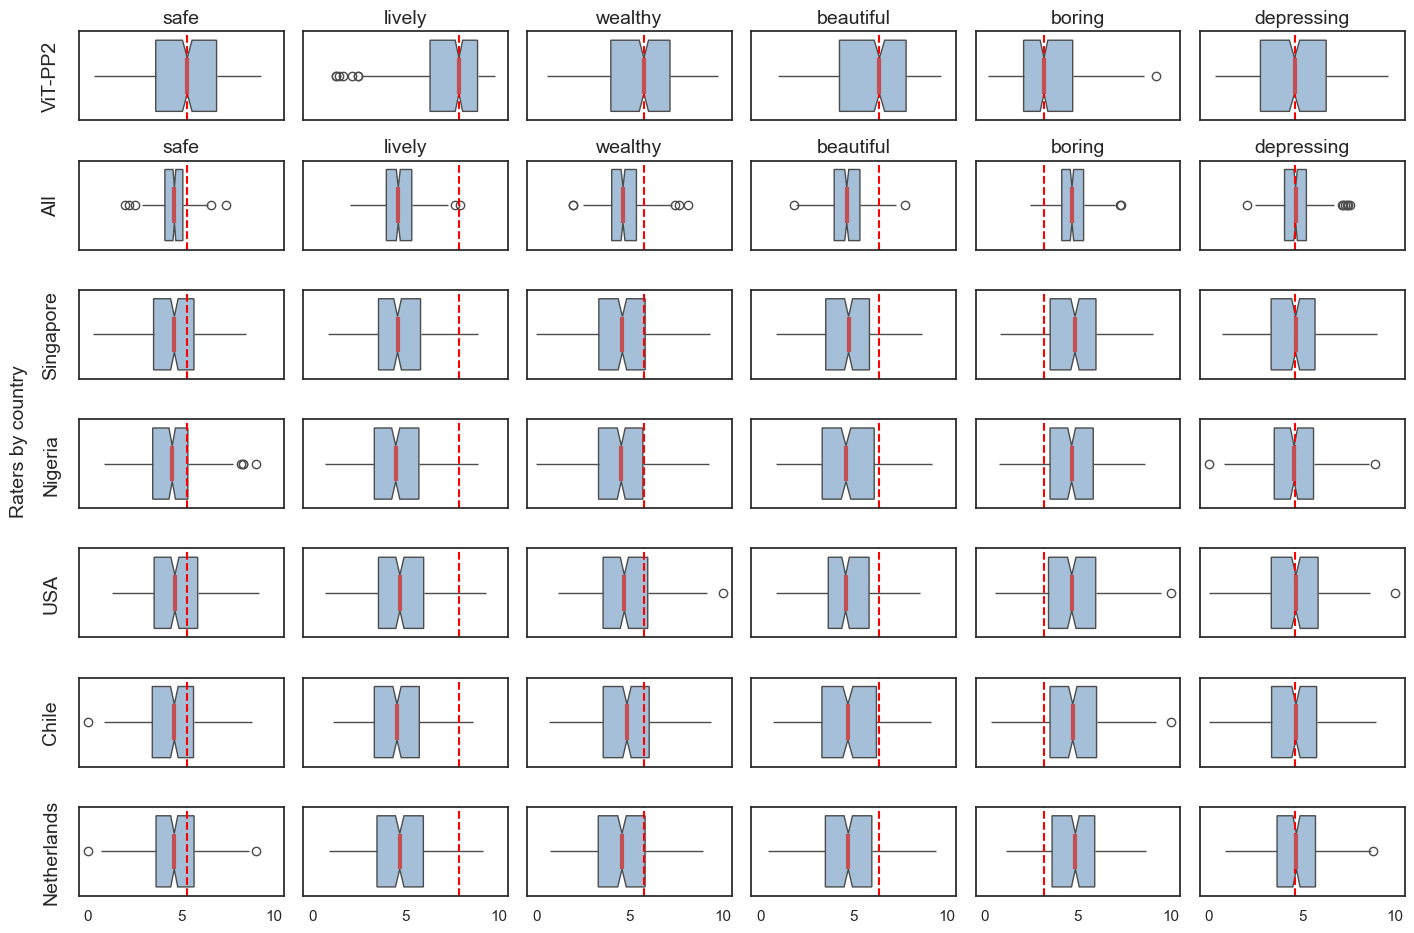

In [7]:
avg_threshold = 4

# create a dataframe to then save it as csv
avg_df = pd.melt(df_pp2, id_vars=['uuid'], value_vars=['safe', 'lively', 'wealthy', 'beautiful', 'boring', 'depressing'], var_name='Question', value_name='Score')
avg_df = avg_df.rename(columns={'uuid': 'Image'})
avg_df['Country'] = 'ViT-PP2'
avg_df['Num_comparisons'] = 4

fig, axes = plt.subplots(
    2 + num_countries, num_indicators_pp2, figsize=(14, 10), sharey=True, sharex=True
)

sns.set(style="white")
fontsize = 14
plot_args = {
    'notch': True, 
    'showcaps': False,
    'boxprops': {"facecolor": (.3, .5, .7, .5)},
    'medianprops': {"color": "r", "linewidth": 3}
}

min_sample_size = 400

# Store medians for the first row
medians_first_row = []

# Plot the first row of boxplots
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_pp2[ind]
    
    # Calculate median of the first row for vertical line
    median_value = ind_df.median()
    medians_first_row.append(median_value)

    ax = axes[0, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df,
        ax=ax,
        **plot_args,
    )
    
    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("ViT-PP2", size=fontsize)

# Plot the second row of boxplots (all countries combined)
df_scores = calculate_qscore(raw_df)
df_scores_filtered = df_scores[df_scores['Num_comparisons'] >= avg_threshold]
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_scores_filtered[df_scores_filtered['Question'] == ind]
    ind_df.loc[:, 'Country'] = 'All'
    
    avg_df = pd.concat([avg_df, ind_df], ignore_index=True)
    
    ax = axes[1, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df['Score'],
        ax=ax,
        **plot_args,
    )
    # Draw the vertical line using the median from the first row
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)
    
    if min_sample_size > len(ind_df):
        min_sample_size = len(ind_df)
        
    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("All", size=fontsize)

# Plot the remaining rows of boxplots and add vertical lines
for j, c in enumerate(countries):
    country_df = raw_df[raw_df['Country'] == c]
    country_df_scores = calculate_qscore(country_df)
    country_df_scores_filtered = country_df_scores[country_df_scores['Num_comparisons'] >= avg_threshold]
    country_df_scores_filtered['Country'] = c
    avg_df = pd.concat([avg_df, country_df_scores_filtered], ignore_index=True)
    
    for i, ind in enumerate(indicators_pp2):
        # Filter by indicator
        ind_df = country_df_scores_filtered[country_df_scores_filtered['Question'] == ind]
    
        ax = axes[j + 2, i]  # Use the shared axes
    
        sns.boxplot(
            x=ind_df['Score'],
            ax=ax,
            **plot_args,
        )
    
        ax.set_xlabel("")
        ax.set_ylabel(c, size=fontsize)

        # Draw the vertical line using the median from the first row
        ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

        if min_sample_size > len(ind_df):
            min_sample_size = len(ind_df)
    
# Draw vertical lines for the first row boxplots (if you want them to extend across the first row as well)
for i, ax in enumerate(axes[0, :]):
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

# Add a shared y-axis label
print(f'Min sample size across all subgroups and indicators: {min_sample_size}')
fig.text(-0.01, 0.5, 'Raters by country', va='center', rotation='vertical', fontsize=fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to leave space for suptitle
plt.savefig(f"img/{save_file}_{avg_threshold}.png", dpi=300)
plt.show()

# ViT-PP2 has 2 decimal points for precision
avg_df['Score'] = round(avg_df['Score'], 2)
avg_df.to_csv(f'data/labels/processed/{save_file}_{avg_threshold}.csv')

## Max

/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/2422725640.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/2422725640.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/2422725640.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Min sample size across all subgroups and indicators: 44


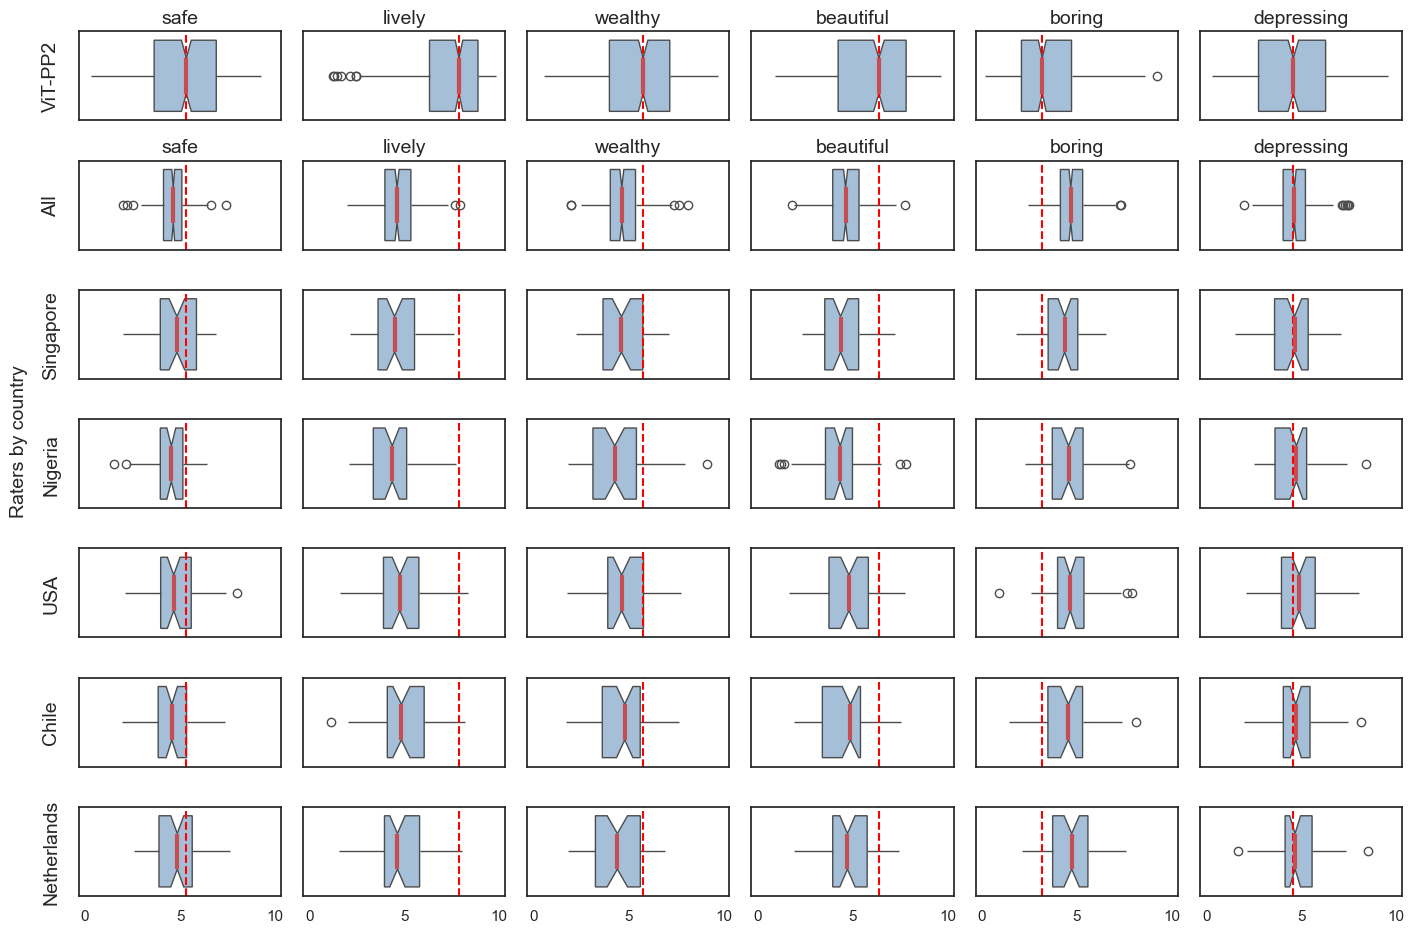

In [8]:
max_threshold = 8

# create a dataframe to then save it as csv
max_df = pd.melt(df_pp2, id_vars=['uuid'], value_vars=['safe', 'lively', 'wealthy', 'beautiful', 'boring', 'depressing'], var_name='Question', value_name='Score')
max_df = max_df.rename(columns={'uuid': 'Image'})
max_df['Country'] = 'ViT-PP2'
max_df['Num_comparisons'] = 4

fig, axes = plt.subplots(
    2 + num_countries, num_indicators_pp2, figsize=(14, 10), sharey=True, sharex=True
)

sns.set(style="white")
fontsize = 14
plot_args = {
    'notch': True, 
    'showcaps': False,
    'boxprops': {"facecolor": (.3, .5, .7, .5)},
    'medianprops': {"color": "r", "linewidth": 3}
}

min_sample_size = 400

# Store medians for the first row
medians_first_row = []

# Plot the first row of boxplots
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_pp2[ind]
    
    # Calculate median of the first row for vertical line
    median_value = ind_df.median()
    medians_first_row.append(median_value)

    ax = axes[0, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df,
        ax=ax,
        **plot_args,
    )
    
    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("ViT-PP2", size=fontsize)

# Plot the second row of boxplots (all countries combined)
df_scores = calculate_qscore(raw_df)
df_scores_filtered = df_scores[df_scores['Num_comparisons'] >= max_threshold]
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_scores_filtered[df_scores_filtered['Question'] == ind]
    ind_df.loc[:, 'Country'] = 'All'
    
    max_df = pd.concat([max_df, ind_df], ignore_index=True)
    
    ax = axes[1, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df['Score'],
        ax=ax,
        **plot_args,
    )
    # Draw the vertical line using the median from the first row
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

    if min_sample_size > len(ind_df):
        min_sample_size = len(ind_df)

    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("All", size=fontsize)

# Plot the remaining rows of boxplots and add vertical lines
for j, c in enumerate(countries):
    country_df = raw_df[raw_df['Country'] == c]
    country_df_scores = calculate_qscore(country_df)
    country_df_scores_filtered = country_df_scores[country_df_scores['Num_comparisons'] >= max_threshold]
    country_df_scores_filtered['Country'] = c
    max_df = pd.concat([max_df, country_df_scores_filtered], ignore_index=True)
    
    for i, ind in enumerate(indicators_pp2):
        # Filter by indicator
        ind_df = country_df_scores_filtered[country_df_scores_filtered['Question'] == ind]
    
        ax = axes[j + 2, i]  # Use the shared axes
    
        sns.boxplot(
            x=ind_df['Score'],
            ax=ax,
            **plot_args,
        )
    
        ax.set_xlabel("")
        ax.set_ylabel(c, size=fontsize)

        # Draw the vertical line using the median from the first row
        ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

        if min_sample_size > len(ind_df):
            min_sample_size = len(ind_df)

# Draw vertical lines for the first row boxplots (if you want them to extend across the first row as well)
for i, ax in enumerate(axes[0, :]):
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

# Add a shared y-axis label
print(f'Min sample size across all subgroups and indicators: {min_sample_size}')
fig.text(-0.01, 0.5, 'Raters by country', va='center', rotation='vertical', fontsize=fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to leave space for suptitle
plt.savefig(f"img/{save_file}_{max_threshold}.png", dpi=300)
plt.show()

# ViT-PP2 has 2 decimal points for precision
max_df['Score'] = round(max_df['Score'], 2)
max_df.to_csv(f'data/labels/processed/{save_file}_{max_threshold}.csv')

In [9]:
# overestimate positive indicators 
# underestimate negative indicators

## Variable

/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/540205834.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/540205834.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_df.loc[:, 'Country'] = 'All'
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_23228/540205834.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Min sample size across all subgroups and indicators: 21


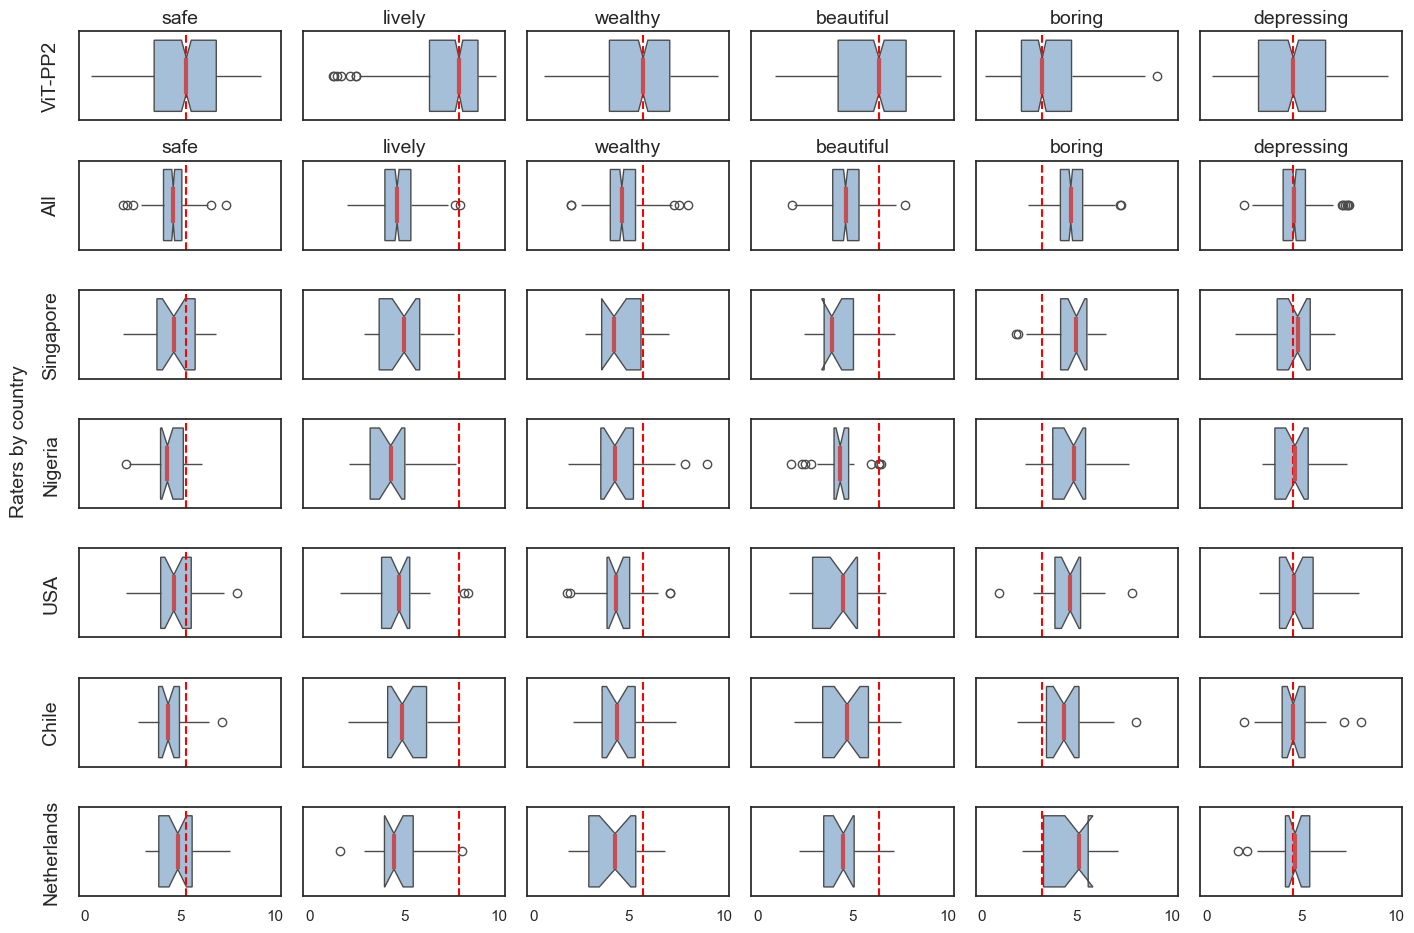

In [10]:
var_threshold = 9

# create a dataframe to then save it as csv
var_df = pd.melt(df_pp2, id_vars=['uuid'], value_vars=['safe', 'lively', 'wealthy', 'beautiful', 'boring', 'depressing'], var_name='Question', value_name='Score')
var_df = var_df.rename(columns={'uuid': 'Image'})
var_df['Country'] = 'ViT-PP2'
var_df['Num_comparisons'] = 4

fig, axes = plt.subplots(
    2 + num_countries, num_indicators_pp2, figsize=(14, 10), sharey=True, sharex=True
)

sns.set(style="white")
fontsize = 14
plot_args = {
    'notch': True, 
    'showcaps': False,
    'boxprops': {"facecolor": (.3, .5, .7, .5)},
    'medianprops': {"color": "r", "linewidth": 3}
}

min_sample_size = 400

# Store medians for the first row
medians_first_row = []

# Plot the first row of boxplots
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_pp2[ind]
    
    # Calculate median of the first row for vertical line
    median_value = ind_df.median()
    medians_first_row.append(median_value)

    ax = axes[0, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df,
        ax=ax,
        **plot_args,
    )
    
    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("ViT-PP2", size=fontsize)

# Plot the second row of boxplots (all countries combined)
df_scores = calculate_qscore(raw_df)
df_scores_filtered = df_scores[df_scores['Num_comparisons'] >= var_threshold]
for i, ind in enumerate(indicators_pp2):
    # Filter by indicator
    ind_df = df_scores_filtered[df_scores_filtered['Question'] == ind]
    ind_df.loc[:, 'Country'] = 'All'
    
    var_df = pd.concat([var_df, ind_df], ignore_index=True)
    
    ax = axes[1, i]  # Use the shared axes

    sns.boxplot(
        x=ind_df['Score'],
        ax=ax,
        **plot_args,
    )
    # Draw the vertical line using the median from the first row
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

    if min_sample_size > len(ind_df):
        min_sample_size = len(ind_df)

    ax.set_title(f"{ind}", size=fontsize)
    ax.set_xlabel("")
    ax.set_ylabel("All", size=fontsize)

# Plot the remaining rows of boxplots and add vertical lines
for j, c in enumerate(countries):
    country_df = raw_df[raw_df['Country'] == c]
    country_df_scores = calculate_qscore(country_df)
    country_df_scores_filtered = country_df_scores[country_df_scores['Num_comparisons'] >= var_threshold]
    country_df_scores_filtered['Country'] = c
    var_df = pd.concat([var_df, country_df_scores_filtered], ignore_index=True)
    
    for i, ind in enumerate(indicators_pp2):
        # Filter by indicator
        ind_df = country_df_scores_filtered[country_df_scores_filtered['Question'] == ind]
    
        ax = axes[j + 2, i]  # Use the shared axes
    
        sns.boxplot(
            x=ind_df['Score'],
            ax=ax,
            **plot_args,
        )
    
        ax.set_xlabel("")
        ax.set_ylabel(c, size=fontsize)

        # Draw the vertical line using the median from the first row
        ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

        if min_sample_size > len(ind_df):
            min_sample_size = len(ind_df)
        # print(f'\nCountry: {c}')
        # print(f'Question: {ind}')
        # print(f'sample size of {len(ind_df)}')

# Draw vertical lines for the first row boxplots (if you want them to extend across the first row as well)
for i, ax in enumerate(axes[0, :]):
    ax.axvline(medians_first_row[i], color='red', linestyle='--', linewidth=1.5)

# Add a shared y-axis label
print(f'Min sample size across all subgroups and indicators: {min_sample_size}')
fig.text(-0.01, 0.5, 'Raters by country', va='center', rotation='vertical', fontsize=fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to leave space for suptitle
plt.savefig(f"img/{save_file}_{var_threshold}.png", dpi=300)

plt.show()

# ViT-PP2 has 2 decimal points for precision
var_df['Score'] = round(var_df['Score'], 2)
var_df.to_csv(f'data/labels/processed/{save_file}_{var_threshold}.csv')